# Analysis of a selected tide gauge record : Le Conquet

## 0. Présentation du site

Le Conquet est une ville française située à l'extrême ouest de la Bretagne.

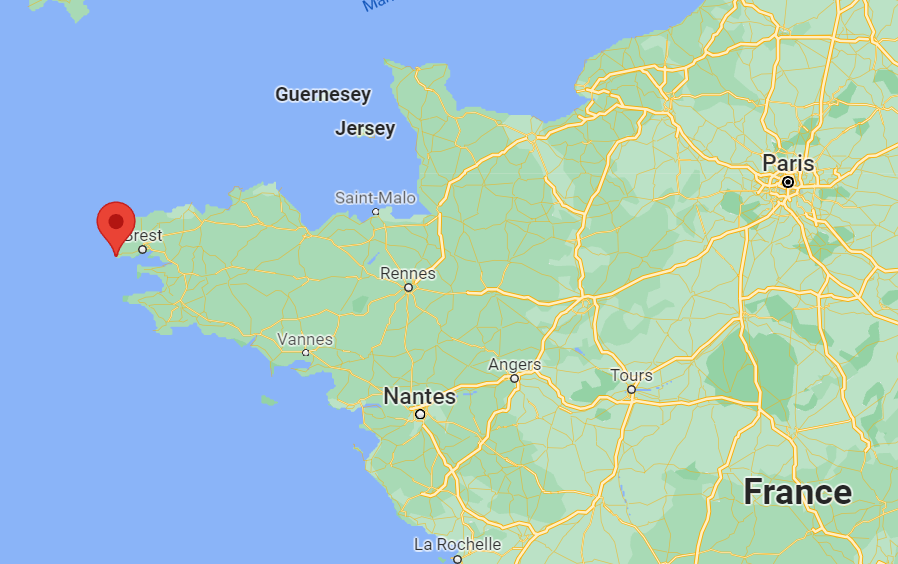
                                                                        (c) Google Maps

L'objectif de ce travail est d'étudier les niveaux marins relevés par le marégraphe du Conquet. On veut voir les probabilités d'obtenir certaines hauteurs d'eau et certaines hauteurs de surges.
Grâce aux lois de Gumbel et de GEV sur des données annuelles, il est possible de construire des modèles de probabilités et de pouvoir donner les tendances liées aux observations. 

Dans ce travail, nous allons suivre le plan suivant :

- Dans une première partie, nous allons travailler sur les données moyennées à l'année. Nous allons développer une méthode empirique pour calculer les périodes de retour et les probablités d'observer une certaine hauteur d'eau au Conquet. Nous travaillerons ensuite avec les lois de probabilité de Gumbel et GEV pour construire des modèles de probabilité et les comparer à notre modèle empirique.

- Dans une seconde partie, nous allons reprendre la méthode de Bernard Simon qui se concentre sur les surges des marées, c'est-à-dire la différence entre la hauteur d'eau prédite par les relations astronomiques et la hauteur d'eau réellement observée.

L'intérêt ici repose sur la comparaison des résultats, ainsi que d'obtenir la méthode la plus précise possible.

## 1. Analyse annuelle
### 1.0 Imports et fonctions

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy
from scipy.stats import genextreme as gev
from scipy.stats import gumbel_r as gumb
import pandas as pd
import utide as utide 
import math

def exceeding(sl): 
    # permet de calculer la propabilité de dépasser un niveau d'eau que l'on renseigne.
    n=len(df_annual.values)
    h=0
    
    for i in df_annual.values:
        if i>=sl:
            h=h+1
    
    p = h/n
    return p

def utime(dtindex): 
    # transform from pandas.DatetimeIndex to utide time
    return dates.date2num(dtindex.to_pydatetime())

def dparser(y,m,d,h,n,s):
    # permet de bien mettre en forme les indexs datetime
    return pd.to_datetime(f"{y}/{m}/{d} {h}:{n}:{s}",format='%Y/%m/%d %H:%M:%S')

def T_to_eta(df_max,T):
    # permet de calculer les périodes de retour
    max_sorted=np.sort(df_max.values, axis=0)[::-1]

    p=(75/T)

    eta=max_sorted[int(p)-1]
    print(f" Pour une période de retour de {T} années, l'hauteur d'eau est égale à {eta} mètres")
    if T > 21:
        print(f"Attention ! Période de retour supérieure au temps d'observation !")
    
    
print(f"pandas version = {pd.__version__}")
print(f"utide version = {utide.__version__}")
print(f"numpy version = {np.__version__}")
print(f"matplotlib version = {matplotlib.__version__}")
print(f"scipy version = {scipy.__version__}")

pandas version = 1.2.4
utide version = 0.2.6
numpy version = 1.20.1
matplotlib version = 3.3.4
scipy version = 1.6.2


### 1.1 Load data

C:\Users\regie\anaconda3\lib\site-packages\pandas\io\parsers.py:3339: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


,SL
datetime,
1971-01-01 00:00:00,1.39
1971-01-01 01:00:00,1.25
1971-01-01 02:00:00,1.77
1971-01-01 03:00:00,3.02
1971-01-01 04:00:00,4.37
...,...
1995-12-31 19:00:00,2.87
1995-12-31 20:00:00,3.24
1995-12-31 21:00:00,3.90


Text(0, 0.5, "Hauteurs d'eau en mètres")

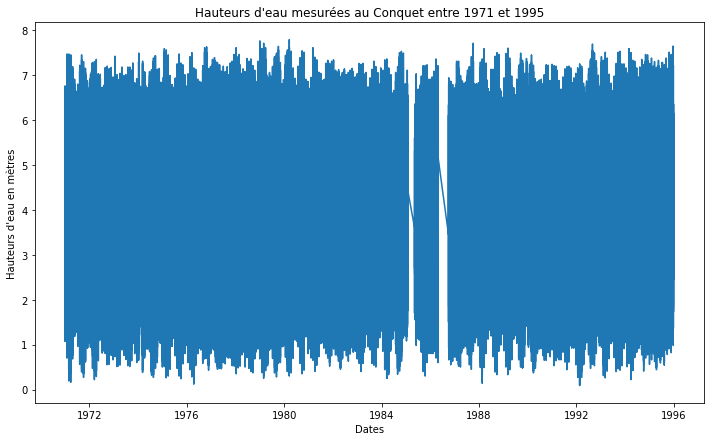

In [2]:
dfC= pd.read_csv("LeConquet_1971_1995.dat",delim_whitespace=True,usecols=[0,1,2,3,4,5,6],names=["y","m","j","h","n","s","SL"],
                 parse_dates={'datetime':[0,1,2,3,4,5]},date_parser=dparser)
dfC.set_index('datetime',inplace=True)

dfC=dfC[dfC['SL'].notna()]

display(dfC)

plt.figure(figsize=[12,7])
plt.plot(dfC)
plt.title("Hauteurs d'eau mesurées au Conquet entre 1971 et 1995")
plt.xlabel("Dates")
plt.ylabel("Hauteurs d'eau en mètres")

La série observée au Conquet s'étend de 1971 à 1995 avec deux arrêts en 1985 et 1986. Les hauteurs d'eau sont toutes positives par rapport à la référence.

### 1.2 Description statistique des données

count    209998.000000
mean          3.905490
std           1.563883
min           0.090000
25%           2.610000
50%           3.910000
75%           5.200000
max           7.780000
Name: SL, dtype: float64
99%    6.9
99.9%    7.34


Text(0, 0.5, "Nombre d'occurence")

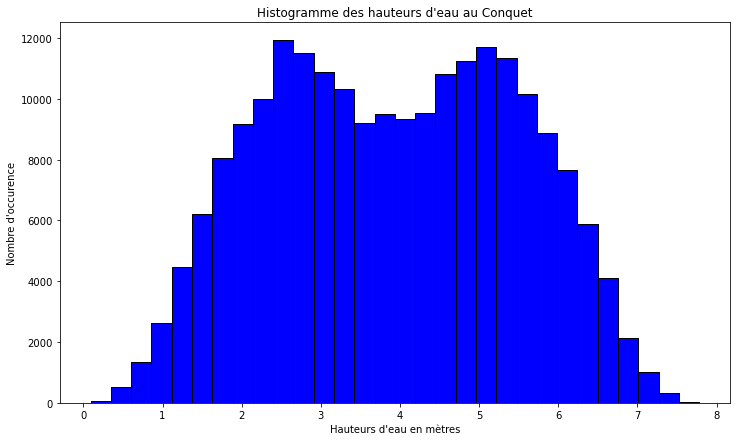

In [3]:
print(dfC['SL'].describe())
print(f"99%    {np.percentile(dfC['SL'],99)}")
print(f"99.9%    {np.percentile(dfC['SL'],99.9)}")

plt.figure(figsize=[12,7])
plt.hist(dfC,color = 'blue',edgecolor = 'black',bins= 30)
plt.title("Histogramme des hauteurs d'eau au Conquet")
plt.xlabel("Hauteurs d'eau en mètres")
plt.ylabel("Nombre d'occurence")

Nous avons presque 210 000 valeurs d'hauteur d'eau, pour une moyenne autour de 3.9 mètres. En construisant l'histogramme des hauteurs d'eau, on peut observer une distribution bimodale du nombre d'occurence. Ce résultat montre ainsi le caractère semi-diurne des marées de la côte bretonne française. 

### 1.3 Maximums annuels et périodes de retour

 Pour une période de retour de 3 années, l'hauteur d'eau est égale à 7.22 mètres
 Pour une période de retour de 5 années, l'hauteur d'eau est égale à 7.48 mètres
 Pour une période de retour de 10 années, l'hauteur d'eau est égale à 7.62 mètres
 Pour une période de retour de 15 années, l'hauteur d'eau est égale à 7.68 mètres
 Pour une période de retour de 20 années, l'hauteur d'eau est égale à 7.7 mètres
 Pour une période de retour de 30 années, l'hauteur d'eau est égale à 7.75 mètres
Attention ! Période de retour supérieure au temps d'observation !
 Pour une période de retour de 50 années, l'hauteur d'eau est égale à 7.78 mètres
Attention ! Période de retour supérieure au temps d'observation !


<Figure size 432x288 with 0 Axes>

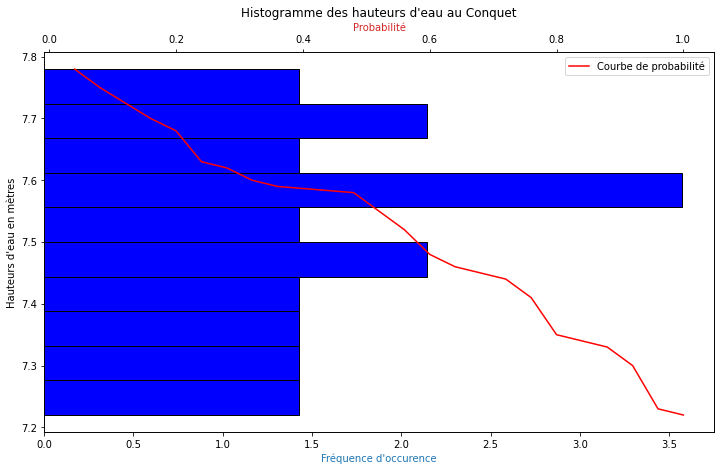

In [4]:
df_annual=dfC['SL'].groupby(by=dfC.index.year).max()

periods=[3,5,10,15,20,30,50]
for T in periods:
    T_to_eta(df_annual,T)

plt.figure()
fig, ax1 = plt.subplots(figsize=[12,7])
plt.title("Histogramme des hauteurs d'eau au Conquet")
ax1.hist(df_annual,color = 'blue',edgecolor = 'black',bins= 10,density=True,orientation='horizontal')
ax1.set_ylabel("Hauteurs d'eau en mètres")
ax1.set_xlabel("Fréquence d'occurence",color='tab:blue')

p_sup_max=[]
maxi=[]
max_sorted=np.sort(df_annual.values, axis=0)[::-1]

for j in max_sorted:
    p = exceeding(j)
    p_sup_max.append(p)
    maxi.append(j)
    
ax2 = ax1.twiny()    
ax2.plot(p_sup_max,maxi,'r',label="Courbe de probabilité")
ax2.set_xlabel("Probabilité",color='tab:red')
plt.legend()

Ici, nous nous intéressons seulement aux maximums des hauteurs d'eau annuelles. Elles sont toutes supérieures à 7 mètres. Le but est de savoir quelles hauteurs d'eau sont atteintes pour des périodes de retour données.

En calculant les périodes de retour, on peut voir que plus une hauteur d'eau est élevée, plus sa période de retour est longue. **Ainsi les événements de forte intensité d'hauteur d'eau sont beaucoup moins fréquents que ceux de basses hauteurs d'eau.** 
La courbe rouge de probabilité confirme cette tendance. La probabilité baisse fortement plus les valeurs d'hauteur d'eau sont élevées.

Il est aussi important de noter qu'il est très dangereux de trouver des périodes de retour supérieures à la période d'observation. En effet, **l'extrapolation des données peut donner des valeurs aberrantes**. Ici, les valeurs associées à des périodes de retour de 30 et 50 ans (bien supérieures au 24 ans des observations) sont ici dans un ordre de grandeur convenable mais il faut rester vigilant.

### 1.4 lois GEV & Gumbel

===== GEV =====
3 ans = 7.6 m
5 ans = 7.65 m
10 ans = 7.7 m
15 ans = 7.73 m
20 ans = 7.74 m
30 ans = 7.76 m | Attention 30 ans plus long que période d'étude (21 ans)
50 ans = 7.77 m | Attention 50 ans plus long que période d'étude (21 ans)
===== GUMB =====
3 ans = 7.57 m
5 ans = 7.66 m
10 ans = 7.77 m
15 ans = 7.84 m
20 ans = 7.88 m
30 ans = 7.95 m | Attention 30 ans plus long que période d'étude (21 ans)
50 ans = 8.02 m | Attention 50 ans plus long que période d'étude (21 ans)


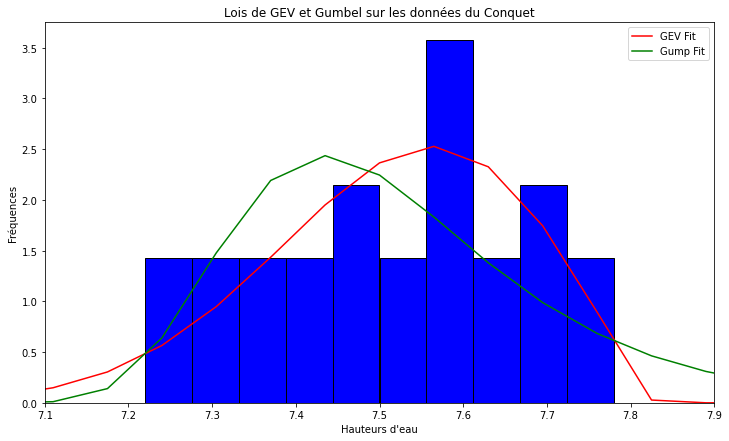

In [5]:
plt.figure(figsize=[12,7])
plt.title("Lois de GEV et Gumbel sur les données du Conquet")
plt.hist(df_annual,color = 'blue',edgecolor = 'black',bins= 10,density=True)
plt.xlabel("Hauteurs d'eau")
plt.ylabel("Fréquences")
plt.xlim(7.1,7.9)

paramgev = gev.fit(df_annual.values)
# paramfit =  (0.1910926717622654, 3.887429360278346, 0.21111432173603356)
x = np.linspace(np.min(df_annual.values)-0.5,np.max(df_annual.values)+0.5,25)
gpdf = gev.pdf(x, *paramgev)
plt.plot(x, gpdf, 'r-', label='GEV Fit')
print("===== GEV =====")
# 3-yr return period
p_3=1/3
gev_3=gev.ppf(1-p_3, *paramgev)
print(f"3 ans = {round(gev_3,2)} m")
# 5-yr return period
p_5=1/5
gev_5=gev.ppf(1-p_5, *paramgev)
print(f"5 ans = {round(gev_5,2)} m")
# 10-yr return period
p_10=1/10
gev_10=gev.ppf(1-p_10, *paramgev)
print(f"10 ans = {round(gev_10,2)} m")
# 15-yr return period
p_15=1/15
gev_15=gev.ppf(1-p_15, *paramgev)
print(f"15 ans = {round(gev_15,2)} m")
# 20-yr return period
p_20=1/20
gev_20=gev.ppf(1-p_20, *paramgev)
print(f"20 ans = {round(gev_20,2)} m")
# 30-yr return period
p_30=1/30
gev_30=gev.ppf(1-p_30, *paramgev)
print(f"30 ans = {round(gev_30,2)} m | Attention 30 ans plus long que période d'étude (21 ans)")
# 50-yr return period
p_50=1/50
gev_50=gev.ppf(1-p_50, *paramgev)
print(f"50 ans = {round(gev_50,2)} m | Attention 50 ans plus long que période d'étude (21 ans)")

# Fitting the Gumbel distribution
param_gumb = gumb.fit(df_annual.values)
#param_gumb = (3.8665750552378446, 0.202857973302924)
gumb_pdf = gumb.pdf(x, *param_gumb)
plt.plot(x,gumb_pdf,'g',label='Gump Fit')
plt.legend()
print("===== GUMB =====")
# 3-yr return period
gumb_3=gumb.ppf(1-p_3, *param_gumb)
print(f"3 ans = {round(gumb_3,2)} m")
# 5-yr return period
gumb_5=gumb.ppf(1-p_5, *param_gumb)
print(f"5 ans = {round(gumb_5,2)} m")
# 10-yr return period
gumb_10=gumb.ppf(1-p_10, *param_gumb)
print(f"10 ans = {round(gumb_10,2)} m")
# 15-yr return period
gumb_15=gumb.ppf(1-p_15, *param_gumb)
print(f"15 ans = {round(gumb_15,2)} m")
# 20-yr return period
gumb_20=gumb.ppf(1-p_20, *param_gumb)
print(f"20 ans = {round(gumb_20,2)} m")
# 30-yr return period
gumb_30=gumb.ppf(1-p_30, *param_gumb)
print(f"30 ans = {round(gumb_30,2)} m | Attention 30 ans plus long que période d'étude (21 ans)")
# 50-yr return period
gumb_50=gumb.ppf(1-p_50, *param_gumb)
print(f"50 ans = {round(gumb_50,2)} m | Attention 50 ans plus long que période d'étude (21 ans)")

Pour résoudre ce problème de durée d'observation, nous utilisons les lois de probabilité de GEV et Gumbel : **elles nous permettent de créer des lois de probabilités de mêmes paramètres que les observations**. Ainsi, on peut travailler sur des durées supérieures à la durée d'observations avec des risques d'erreurs moindres, même s'ils existent toujours. 

On peut voir sur le graphique ci-dessus les lois par rapport à l'histogramme des maximums annuels. Nous pouvons voir que la loi de Gumb semble mieux représenter les données que la loi de GEV. 

On peut également noter les différences quand aux valeurs d'hauteurs d'eau pour les différentes périodes de retour par rapport au calcul empirique précédent. Les estimations de GEV et Gumbel sont plus élevées que les estimations empiriques.

**Mais quelle loi permet de mieux définir nos observations ?** Nous allons représenter les données de différentes façons afin d'obtenir des éléments de réponse.

### 1.5 Plots de comparaison

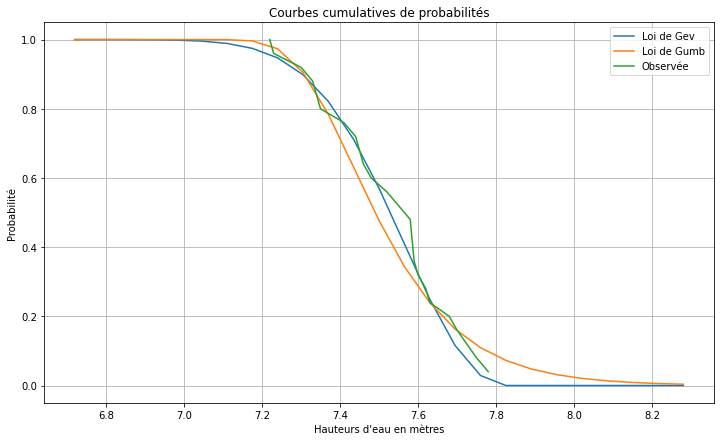

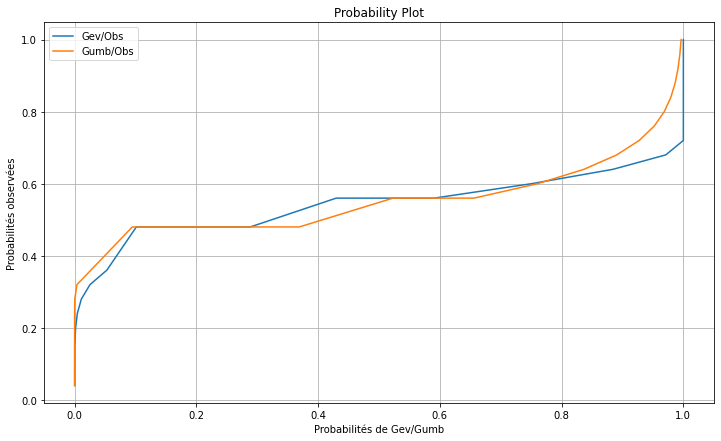

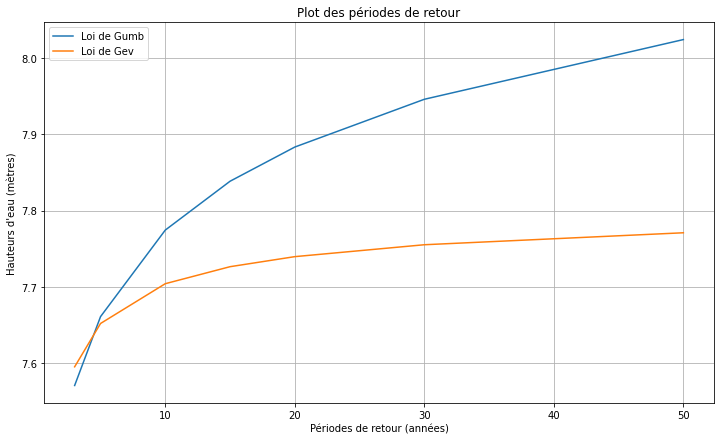

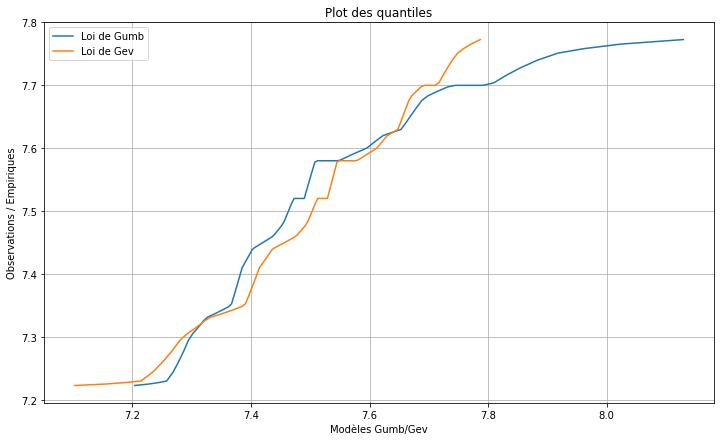

In [6]:
cdf_gev=gev.cdf(x,*paramgev)
cdf_gumb=gumb.cdf(x,*param_gumb)

# Courbes cumulatives de probabilité
plt.figure(figsize=[12,7])
plt.title("Courbes cumulatives de probabilités")
plt.plot(x,1-cdf_gev,label='Loi de Gev')
plt.plot(x,1-cdf_gumb,label='Loi de Gumb')
plt.plot(maxi,p_sup_max,label='Observée')
plt.xlabel("Hauteurs d'eau en mètres")
plt.ylabel("Probabilité")
plt.grid()
plt.legend()

# Courbes des rapports des probabilités
plt.figure(figsize=[12,7])
plt.title("Probability Plot")
plt.plot(cdf_gev,p_sup_max,label="Gev/Obs")
plt.plot(cdf_gumb,p_sup_max,label='Gumb/Obs')
plt.xlabel("Probabilités de Gev/Gumb")
plt.ylabel("Probabilités observées")
plt.grid()
plt.legend()


# Courbes des périodes de retour
plt.figure(figsize=[12,7])
plt.title("Plot des périodes de retour")
plt.plot([3,5,10,15,20,30,50],[gumb_3,gumb_5,gumb_10,gumb_15,gumb_20,gumb_30,gumb_50], label="Loi de Gumb")
plt.plot([3,5,10,15,20,30,50],[gev_3,gev_5,gev_10,gev_15,gev_20,gev_30,gev_50], label='Loi de Gev')
plt.xlabel("Périodes de retour (années)")
plt.ylabel("Hauteurs d'eau (mètres)")
plt.grid()
plt.legend()


# Courbes de l'évolution des quantiles
liste_gumb,liste_gev,quantile=[],[],[]
ranged=np.arange(0,1,0.01)
for j in ranged: 
    liste_gumb.append(gumb.ppf(j,*param_gumb))
    liste_gev.append(gev.ppf(j,*paramgev))
    quantile.append(np.quantile(df_annual,j))
    
plt.figure(figsize=[12,7])
plt.title("Plot des quantiles")
plt.plot(liste_gumb,quantile,label='Loi de Gumb')
plt.plot(liste_gev,quantile,label='Loi de Gev')
plt.xlabel("Modèles Gumb/Gev")
plt.ylabel("Observations / Empiriques")
plt.grid()
plt.legend()

**Graphique des courbes cumulatives**
On peut voir que les trois cdfs des lois de probabilités sont proches entres elles. Elles suivent la même tendance que la courbe empirique, avec néanmoins quelques différences surtout pour les hauteurs d'eau autour de 7.5 mètres. On peut voir les différences que l'on a pu observer sur la figure de distribution des probabilités, mais cette représentation ne permet pas de dire clairement si l'une des méthodes est plus accurate que l'autre.

**Graphique du rapport de probabilité**
Comme sur le graphique des courbes cumulatives, on n'observe que peu de différences entre les résultats des deux lois. Les deux rapports avec les valeurs empiriques ont la même tendance et la même forme.

**Graphique des périodes de retour**
Cette représentation des données est plus intéressante à observer car l'on observe bien une différence entre les deux lois.
La loi de GEV ne donne pas de période de retour pour des hauteurs d'eau supérieures à 7.75 mètres (le maximum des observations au Conquet) en tendant vers cette valeur, alors que la loi de Gumb nous donne des périodes de retour jusqu'à plus de 8 mètres d'eau, pour des périodes de retour jusqu'à 50 ans.

**Graphique des quantiles**
Ici nous représentons l'évolution des quantiles en fonction de la loi de probabilité utilisée. Comme sur le graphique des périodes de retour, la loi de GEV s'arrête brusquement avant le maximum d'hauteur d'eau observé alors que la loi de Gumb va jusqu'aux hauteurs d'eau plus hautes.


__*Loi de Gumb ou loi de GEV ?*__
La loi de Gumb a un avantage par rapport à la loi de GEV, celle-ci permet d'extrapoler à des hauteurs d'eau qui n'ont pas été observées, et permet donc d'envisager des périodes de retour pour ces hauteurs d'eau plus hautes, même si ces résultats ont besoin d'être vérifiés.

# 2.0 Bernard Simon

## 2.1 Utide : résolution et prédiction

In [7]:
t = utime(dfC.index)
coef=utide.solve(t,dfC['SL'],lat=48.36)#,epoch='1970-01-01')
predict=utide.reconstruct(t,coef)
df_pred=pd.DataFrame(data=predict['h'],index=dfC.index,columns=['predicted'])
df_res=pd.DataFrame(data=dfC.SL-df_pred.predicted, columns=['residues'])

solve: matrix prep ... solution ... done.
prep/calcs ... done.


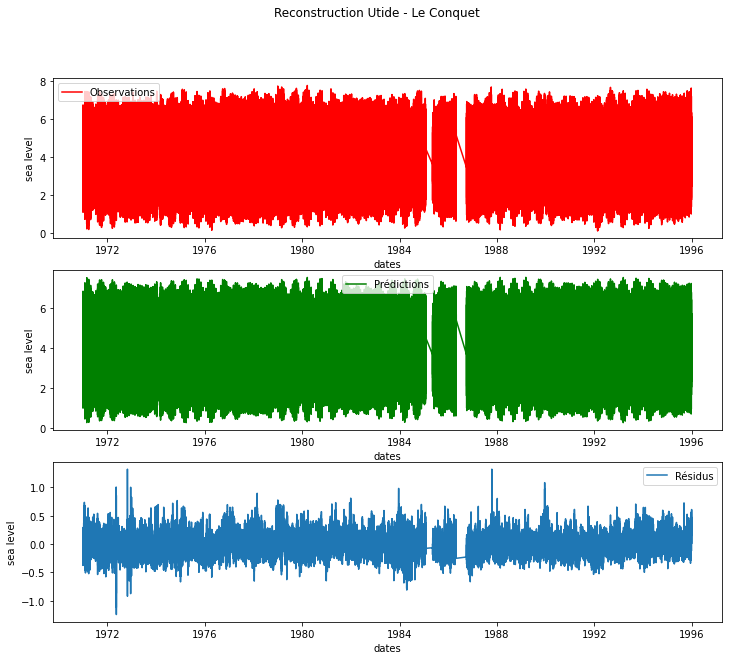

In [8]:
plt.figure(figsize=[12,10])
plt.subplot(311)
plt.suptitle('Reconstruction Utide - Le Conquet')
plt.plot(dfC,'r',label='Observations')
plt.xlabel('dates')
plt.ylabel('sea level')
plt.legend()
plt.subplot(312)
plt.plot(df_pred,'g',label='Prédictions')
plt.xlabel('dates')
plt.ylabel('sea level')
plt.legend()
plt.subplot(313)
plt.plot(df_res,label='Résidus')
plt.xlabel('dates')
plt.ylabel('sea level')
plt.legend()

Cette fois nous allons nous intéresser aux surges, c'est-à-dire à l'écart d'hauteur d'eau entre les niveaux prédits et les niveaux observés. Ces surges peuvent être expliquées par divers facteurs comme l'atmosphère, la météo, le vent ou encore les activités antropiques. 
Pour cela, nous utilisons utide, qui permet de reconstruire les oscillations de marée à partir des données astronomiques. 
En soustrayant les observations par les valeurs de utide, on peut obtenir l'ensemble des surges au Conquet.

In [9]:
#for name,amp,pha in zip(coef['name'],coef['A'],coef['g']):
#    print(f"{name} : amp={amp}  / Phase={pha}")

## 2.2 Surges des marées hautes

In [10]:
e = np.array(df_pred.predicted)

peaks = scipy.signal.find_peaks(e,height=4)
df_predM=pd.DataFrame(peaks[1],index =  df_pred.index[peaks[0]])
df_surge=pd.DataFrame(data=df_res['residues'][peaks[0]])

for i in df_surge.index:
    if df_surge.residues[i]<0:
        df_surge.residues[i]=np.nan

Pour trouver et extraire les surges correspondant aux marées hautes, j'utilise la méthode de find_peaks de scipy sur ma dataframe de prédictions avec un minimum de 4 mètres pour obtenir l'ensemble des marées hautes.
J'ai ensuite utilisé l'index de ces marées hautes et j'ai extrait les surges aux mêmes heures. J'ai ainsi une dataframe avec seulement les surges des marées hautes.

In [11]:
p1 = np.array(df_surge.iloc[:])
p2 = [x for x in p1 if np.isnan(x) == False]

x2=np.linspace(np.min(p2),np.max(p2),100)

param_gumb2 = gumb.fit(p2)
gumb_pdf2 = gumb.pdf(x2, *param_gumb2)

Je reconstruis mes surges de marées hautes en array pour pouvoir créer une loi de probabilité de Gumb suivant les paramètres des surges.

<Figure size 432x288 with 0 Axes>

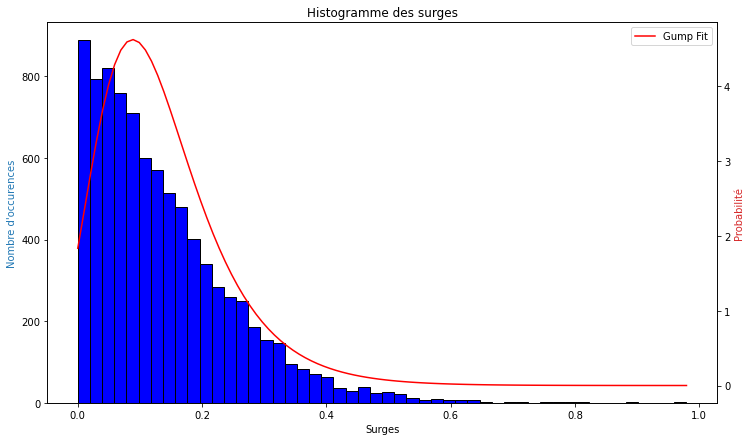

In [12]:
plt.figure()
fig, ax1 = plt.subplots(figsize=[12,7])
plt.title("Histogramme des surges")
ax1.hist(df_surge,color = 'blue',edgecolor = 'black',bins= 50)
ax1.set_ylabel("Nombre d'occurences",color='tab:blue')
ax1.set_xlabel("Surges")

ax2 = ax1.twinx()    
ax2.plot(x2,gumb_pdf2,'r',label='Gump Fit')
ax2.set_ylabel("Probabilité",color='tab:red')
plt.legend()

Voici l'histogramme de distribution des surges et la loi de probabilité Gumb associée. On remarque que la loi est légèrement plus élevée que les observations et plus décalées vers une moyenne de 0.1 mètres. Cependant la courbe répresente assez bien la distribution.

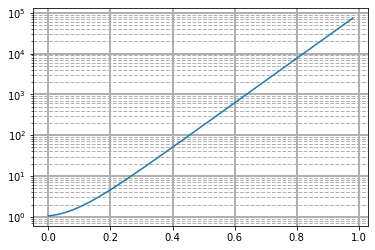

In [13]:
rp=[] #période de retour des surges
p_obs=gumb.sf(x2,*param_gumb2)

for i in range(len(p_obs)):
    rp.append(1/p_obs[i])
    
plt.figure()
plt.plot(x2,rp)
plt.yscale('log')
plt.grid(b=True, which='major', linewidth=2,linestyle='-')
plt.grid(b=True, which='minor', linewidth=1,linestyle='--')

Ici, on représente la période de retour des surges à partir des probabilités d'observation. La probabilité d'observer une hauteur de surge particulière peut être obtenue en utilisant l'attribut sf de la fonction gumb. 
De plus, nous savons que la période de retour est l'inverse de la probabilité d'observation. On peut ainsi reconstruire ce graphique présentant les périodes de retour en fonction de la hauteur de la surge.

En visualisation log.log, on peut voir que les périodes de retour sont linéaires en fonction de la hauteur de surge.

(5.72505297756518, 0.5618114911423456)


<Figure size 432x288 with 0 Axes>

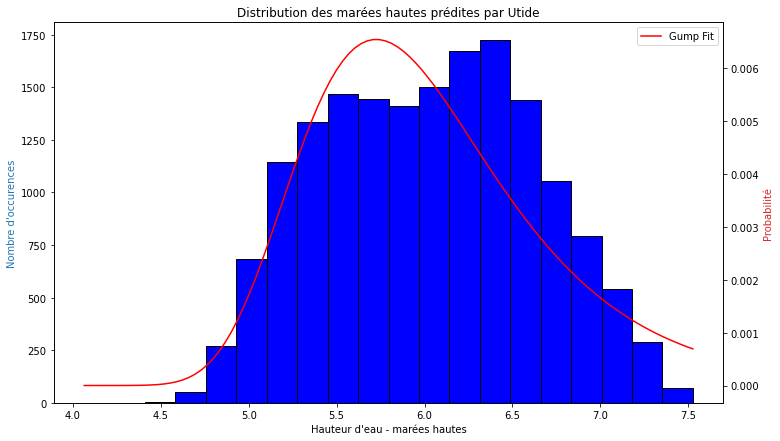

In [14]:
p1 = np.array(df_predM.iloc[:])
p2 = [x for x in p1 if np.isnan(x) == False]
x3=np.linspace(np.min(p2),np.max(p2),100)

param_gumb3 = gumb.fit(p2)
print(param_gumb3)
gumb_pdf3 = gumb.pdf(x3, *param_gumb3)/100

plt.figure()
fig, ax1 = plt.subplots(figsize=[12,7])
plt.title("Distribution des marées hautes prédites par Utide")
ax1.hist(df_predM,color = 'blue',edgecolor = 'black',bins= 20)
ax1.set_ylabel("Nombre d'occurences",color='tab:blue')
ax1.set_xlabel("Hauteur d'eau - marées hautes")
ax2=ax1.twinx()
ax2.plot(x3,gumb_pdf3,'r',label='Gump Fit')
ax2.set_ylabel("Probabilité",color='tab:red')
plt.legend()

Pour pouvoir faire la convolution, on a besoin d'une deuxième série de données. 

Donc on refait le même traitement pour créer une loi de probabilité avec Gumb pour les marées hautes.
On obtient donc la distribution en nombre d'occurence et la courbe des probabilités d'observer des hauteurs de marées hautes au Conquet.

<Figure size 432x288 with 0 Axes>

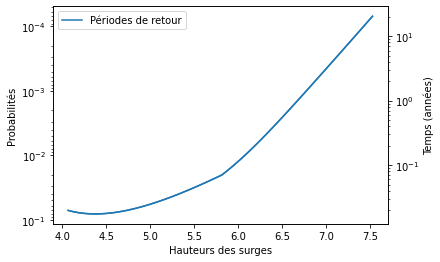

In [15]:
convolution = np.convolve(p_obs,gumb_pdf3,'same') #probabilité

return_periods_obsr=[]
for i in convolution:
    return_periods_obsr.append(1/(705.8*i))#705,8 = nombre de marées hautes en moyenne / an

plt.figure()
fig,ax1=plt.subplots()
ax1.plot(x3,convolution,label='Probabilités')
ax1.invert_yaxis()
plt.yscale('log')
ax1.set_ylabel('Probabilités')
plt.xlabel("Hauteurs des surges")
ax2=ax1.twinx()
ax2.plot(x3,return_periods_obsr,label='Périodes de retour')
ax2.set_ylabel('Temps (années)')
plt.yscale('log')
plt.legend()

Si l'on regarde les résultats on peut voir que les deux courbes se superposent parfaitement.
Les résultats sont lisibles au dessus d'un temps égal à 1 année, soit 10^0 années. On voit une courbe linéaire, ce qui montre que le modèle est bon.

# 3. Conclusion

Ainsi à travers ces différentes étapes, nous avons pu observé les hauteurs marégraphiques du Conquet mais également mener à un modèle de prévision statistique des hauteurs d'eau et des surges que l'on pourrait observer.
Néanmoins, il serait nécessaire d'obtenir des données plus longues afin de pouvoir envisager d'obtenir des réponses possiblement vraies pour des périodes de retour plus longues.